# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
06/13/2016 09:36:35  06/14/2016 09:36:35  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 06/13/2016 09:36:35


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-06-05 00:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-06-13 13:18 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-25 06:28 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName('collaborative')

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "50")
sconf.set("spark.executor.memory", "10g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", "Ready!")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code

Pick a clustering algorithm (name of the file that provides a classify(x,y [,threshold]) function)

# Reading the conf file

In [4]:
import json
import copy

BASE_PATH = HDFS_PATH + '/user/robertop/mattia'

conf = {}

conf['split'] = {}
conf['split']['reclistSize'] = 100
conf['split']['callParams'] = {}
conf['split']['excludeAlreadyListenedTest'] = True
conf['split']['name'] = 'test'
conf['split']['split'] = conf['split']['name']
conf['split']['minEventsPerUser'] = 5
conf['split']['inputData'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/SenzaRipetizioni_1'
#conf['split']['inputData'] = 's3n://contentwise-research-poli/30musicdataset/newFormat/relations/sessions.idomaar'
conf['split']['bucketName'] = BASE_PATH
conf['split']['percUsTr'] = 0.05
conf['split']['ts'] = int(0.75 * (1421745857 - 1390209860) + 1390209860) - 10000
conf['split']['minEventPerSession'] = 5
conf['split']['onlineTrainingLength'] = 5
conf['split']['GTlength'] = 1
conf['split']['minEventPerSessionTraining'] = 10
conf['split']['minEventPerSessionTest'] = 11
conf['split']['mode'] = 'session'
conf['split']['forceSplitCreation'] = False
conf['split']["prop"] = {'reclistSize': conf['split']['reclistSize']}
conf['split']['type'] = list
conf['split']['out'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/'
conf['split']['location'] = '30Mdataset/relations/sessions'

conf['evaluation'] = {}
conf['evaluation']['metric'] = {}
conf['evaluation']['metric']['type'] = 'recall'
conf['evaluation']['metric']['prop'] = {}
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
conf['evaluation']['name'] = 'recall@N'

conf['general'] = {}
conf['general']['clientname'] = "clusterBase.split"
conf['general']['bucketName'] = BASE_PATH
conf['general']['tracksPath'] = '30Mdataset/entities/tracks.idomaar.gz'

conf['algo'] = {}
conf['algo']['name'] = 'ClusterBase'
conf['algo']['props'] = {}
# ***** EXAMPLE OF CONFIGURATION *****#
conf['algo']['props']["sessionJaccardShrinkage"] = 5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.1
conf['algo']['props']["expDecayFactor"] = 0.7
# ****** END EXAMPLE ****************#



# Load Songs

In [5]:
import json
import string

def my_replace_punct(x):
    ret = ""
    for i in x:
        if i == '+':
            ret += ' '
        else:
            ret += i
    return ret

tracksRDD = sc.textFile(BASE_PATH + '/30Mdataset/entities/tracks.idomaar.gz')
tracksRDD = tracksRDD.repartition(200)
tracksRDD = tracksRDD.map(lambda x: x.split('\t')).map(lambda x: (x[1], json.loads(x[3])['name'].split('/') ) )
tracksRDD = tracksRDD.map(lambda x: (x[0], " ".join( (x[1][0], x[1][2]) ) )).distinct()
tracksRDD = tracksRDD.map(lambda x : (int(x[0]), my_replace_punct(x[1])))

ZZ_TOP = 3893303
tracksRDD = tracksRDD.filter(lambda x: int(x[0]) < ZZ_TOP)


# Load Clusters

In [5]:
collaborativeClusters = sc.pickleFile(BASE_PATH + '/clusters/collaborative/min_j_25_avgShrink2_higherMean')

songToCollaborative = collaborativeClusters.filter(lambda x: len(x[1]) > 1).flatMap(lambda x: [(int(i), x[0]) for i in x[1]] )

jaccardClusters = sc.pickleFile(BASE_PATH + '/clusters/jaccardBase9')

songToJaccard = jaccardClusters.filter(lambda x: len(x[1]) > 1).flatMap(lambda x: [(int(i), x[0]) for i in x[1]] )

# Names

In [ ]:
songClusterNames = songToCollaborative.join(tracksRDD)
songClusterNames.take(3)

songClusterNames = songToCollaborative.join(tracksRDD)
songClusterNames.take(3)

In [7]:
clustersNames = songClusterNames.map(lambda x: (x[1][0], x[1][1])).groupByKey().mapValues(list)
clustersNames.take(1000)

[(1398672,
  [u'Hot Natured Benediction (Lxury Remix)',
   u'Kodaline High Hopes (Filous Remix)']),
 (2219185,
  [u'John Vanderslice Interlude %232', u'Wildcat! Wildcat! Sentimental']),
 (2888427, [u'Falling in Reverse Born to Lead', u'Maglore O mel e o fel']),
 (3641625, [u'Vanguart Demorou pra Ser', u'Vanguart O Que a Gente Podia Ser']),
 (3333550,
  [u'Deceptikon Tokyo Burning',
   u'Yeah Yeah Yeahs Mosquito - Live From Area 52']),
 (1252176,
  [u'Sepultura The Vatican', u'Matt Monro If I Never Sing Another Song']),
 (210697,
  [u'Laurent Michelotto Paris Accordeon',
   u'Bernard Marly Salut Les Guinguettes']),
 (1855681,
  [u'%D0%9A%D0%BE%D1%81%D0%BC%D0%BE%D0%BD%D0%B0%D0%B2%D1%82%D1%8B%2F%D0%A0%D0%B0%D1%81%D0%BA%D0%BE%D0%BB%D1%8C%D0%BD%D0%B8%D0%BA%D0%BE%D0%B2 %D0%9F%D1%80%D0%BE%D1%89%D0%B0%D0%B9 %D0%BC%D0%BE%D0%BB%D0%BE%D0%B4%D0%BE%D1%81%D1%82%D1%8C',
   u'Dragonette Take It Like a Man']),
 (1256139, [u'nomoton Dog Watch', u'Lebanon Hanover no one holds hands']),
 (1964989,
  [u'%5

In [8]:
songNames = clustersNames.map(lambda x: x[1]).collect()

In [9]:
filename = '/home/jovyan/work/data/mattia/' + 'min_j_25_avgShrink2_3600_songs.csv'
with open(filename, 'w') as f:
    for i in songNames:
        line = '\t'.join([str(s) for s in i]) + '\n'
        f.write(line)

# Stats about Songs

In [10]:
songsRDD = sc.textFile(BASE_PATH + '/30Mdataset/entities/tracks.idomaar.gz')
songsRDD = songsRDD.repartition(200)
songsRDD = songsRDD.map(lambda x: x.split('\t')).map(lambda x: (int(x[1]), json.loads(x[3])['playcount']) ).distinct().filter(lambda x: int(x[0]) < ZZ_TOP and x[1] >= 0)
songsRDD.take(1)

[(1067479, 499)]

In [11]:
songCollaborative = set(songToCollaborative.map(lambda x: x[0]).collect())
songCollBroad = sc.broadcast(songCollaborative)
songsPlayRDD = songsRDD.map(lambda x: (x[0], x[1], 1) if x[0] in songCollBroad.value else (x[0], x[1], 0))

In [12]:
songsPlaySortedRDD = songsPlayRDD.sortBy(lambda x: -x[1])
songPlayIndexRDD = songsPlaySortedRDD.zipWithIndex()

In [13]:
y_tot = songPlayIndexRDD.map(lambda x: x[0][1]).collect()
x_tot = songPlayIndexRDD.map(lambda x: x[1]).collect()

songPlayClustRDD = songPlayIndexRDD.filter(lambda x: x[0][2] == 1)
y_cl = songPlayClustRDD.map(lambda x: x[0][1]).collect()
x_cl = songPlayClustRDD.map(lambda x: x[1]).collect()

cum = 0
y_cum = []
tot_play = sum(y_tot)
for i in (y_tot):
    cum += float(i) / tot_play
    y_cum.append(cum)
    
cum = 0
y_cl_cum = []
tot_play = sum(y_cl)
for i in (y_cl):
    cum += float(i) / tot_play
    y_cl_cum.append(cum)

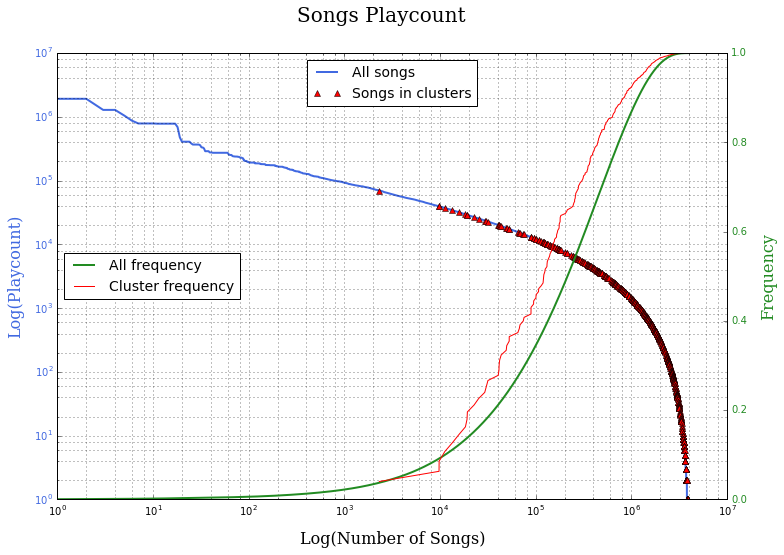

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
font_title = {'family': 'serif',
                   'weight': 'bold',
                   'verticalalignment': 'bottom',
                   'size': 20}  

font_label = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  



fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

plt.suptitle("Songs Playcount", fontsize=20, fontdict = font_title  )

COLOR_1 = 'royalblue'
ax1.loglog(x_tot, y_tot, COLOR_1, linewidth=2.0)
ax1.loglog(x_cl, y_cl , 'r^' , linewidth=2)

ax1.grid(True, which="both")
ax1.set_xlabel('Log(Number of Songs)', fontdict = font_label, labelpad=30)
ax1.set_ylabel('Log(Playcount)', fontdict = font_label, color = COLOR_1,  labelpad=10)
ax1.legend(['All songs', 'Songs in clusters'], fontsize = 14, loc = 9)
for tl in ax1.get_yticklabels():
    tl.set_color(COLOR_1)

COLOR_2 = "forestgreen"
ax2.plot(x_tot, y_cum, COLOR_2,linewidth=2.0)
ax2.plot(x_cl, y_cl_cum, 'r',linewidth=1.0)

ax2.set_ylim(0,1)
ax2.set_ylabel('Frequency', fontdict = font_label, labelpad=30, color = COLOR_2)
ax2.legend(['All frequency', 'Cluster frequency'], fontsize = 14, loc = 6)
for tl in ax2.get_yticklabels():
    tl.set_color(COLOR_2)

# Test / Train  

In [6]:
import json
execfile('../spark-scripts/utilsCluster.py')
train, test = loadDataset(conf)
train = train.map(json.loads)
test = test.map(json.loads)

print train.count()
print test.count()

splitPath = os.path.join(conf['general']['bucketName'], conf['general']['clientname'])
GTpath = os.path.join(splitPath, "GT")
gtRDD = sc.textFile(GTpath).map(lambda x: json.loads(x))

print gtRDD.count()


487637
290262
290262


# Distribution in Train/Test/GT

In [7]:
trainCount = train.flatMap(lambda x: [(i['id'], 1) for i in x['linkedinfo']['objects']]).reduceByKey(lambda x,y: x + y)
testCount = test.flatMap(lambda x: [(i['id'], 1) for i in x['linkedinfo']['objects']]).reduceByKey(lambda x,y: x + y)
gtCount = gtRDD.flatMap(lambda x: [(i['id'], 1) for i in x['linkedinfo']['objects']]).reduceByKey(lambda x,y: x + y)


trainSort = trainCount.sortBy(lambda x: -x[1]).zipWithIndex().map(lambda x: (x[0][0], (x[0][1], x[1])))
testSort = testCount.sortBy(lambda x: -x[1]).zipWithIndex().map(lambda x: (x[0][0], (x[0][1], x[1])))
gtSort = gtCount.sortBy(lambda x: -x[1]).zipWithIndex().map(lambda x: (x[0][0], (x[0][1], x[1])))

In [8]:
trainCollaborative = trainSort.join(songToCollaborative)
testCollaborative = testSort.join(songToCollaborative)
gtCollaborative = gtSort.join(songToCollaborative)

print trainCollaborative.count()
print testCollaborative.count()
print gtCollaborative.count()

593
209
214


In [9]:
trainJaccard = trainSort.join(songToJaccard)
testJaccard = testSort.join(songToJaccard)
gtJaccard = gtSort.join(songToJaccard)

print trainJaccard.count()
print testJaccard.count()
print gtJaccard.count()

150169
48131
48239


In [10]:
#PLaycount of all songs
y_train = trainSort.map(lambda x: x[1][0]).collect()
y_test = testSort.map(lambda x: x[1][0]).collect()
y_gt = gtSort.map(lambda x: x[1][0]).collect()

x_train = trainSort.map(lambda x: x[1][1]).collect()
x_test = testSort.map(lambda x: x[1][1]).collect()
x_gt = gtSort.map(lambda x: x[1][1]).collect()

#Playcont songs in Collaborative
train_cl = trainCollaborative.map(lambda x: x[1][0][1]).collect()
test_cl = testCollaborative.map(lambda x: x[1][0][1]).collect()
gt_cl = gtCollaborative.map(lambda x: x[1][0][1]).collect()

y_train_cl = [y_train[i] for i in train_cl]
y_test_cl = [y_test[i] for i in test_cl]
y_gt_cl = [y_gt[i] for i in gt_cl]

#Playcont songs in Jaccard
train_jac= trainJaccard.map(lambda x: x[1][0][1]).collect()
test_jac = testJaccard.map(lambda x: x[1][0][1]).collect()
gt_jac = gtJaccard.map(lambda x: x[1][0][1]).collect()

y_train_jac = [y_train[i] for i in train_jac]
y_test_jac = [y_test[i] for i in test_jac]
y_gt_jac = [y_gt[i] for i in gt_jac]




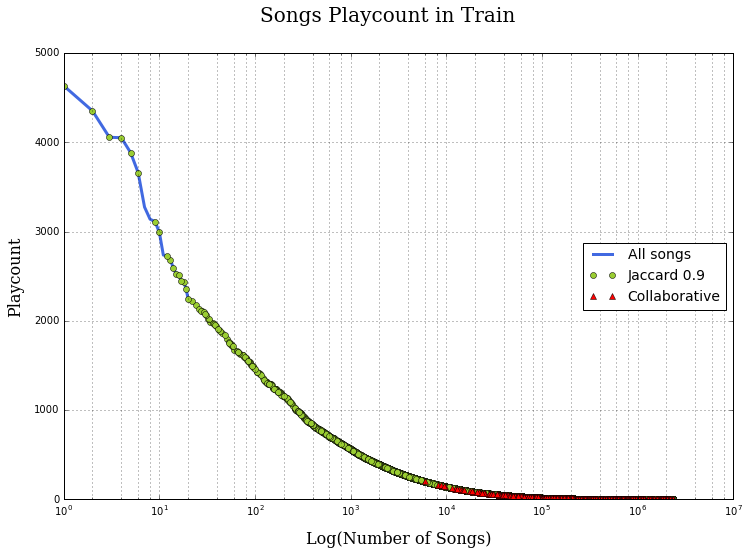

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline
font_title = {'family': 'serif',
                   'weight': 'bold',
                   'verticalalignment': 'bottom',
                   'size': 20}  

font_label = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  



fig, ax1 = plt.subplots(figsize=(12,8))

plt.suptitle("Songs Playcount in Train", fontsize=20, fontdict = font_title  )
ax1.semilogx(x_train, y_train, 'royalblue', linewidth=3)
ax1.semilogx(train_jac, y_train_jac , color='yellowgreen', marker='o', linestyle = 'None', linewidth=1)
ax1.semilogx(train_cl, y_train_cl , color='red', marker='^', linestyle = 'None', linewidth=1)

ax1.grid(True, which="both")
ax1.set_xlabel('Log(Number of Songs)', fontdict = font_label, labelpad=30)
ax1.set_ylabel('Playcount', fontdict = font_label, labelpad=10)
ax1.legend(['All songs', 'Jaccard 0.9', 'Collaborative'], fontsize = 14, loc = 7)

DATA_PATH = '/home/jovyan/work/data/mattia/'
#plt.savefig(DATA_PATH + 'playTrain')

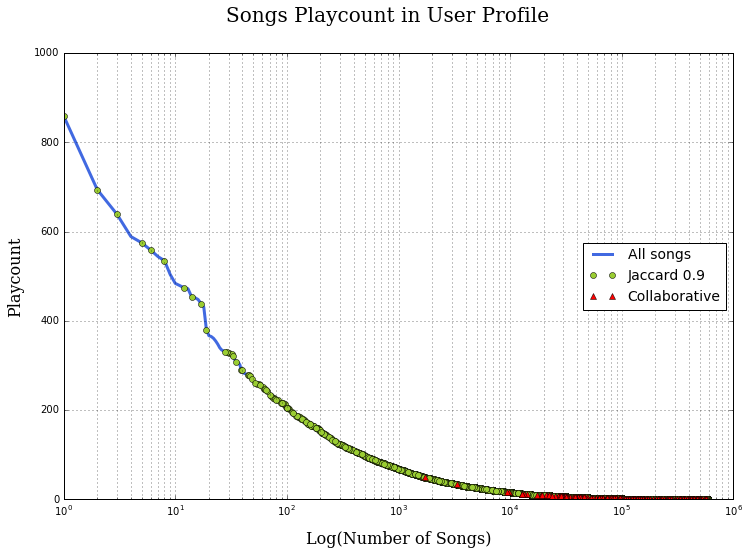

In [33]:
fig, ax1 = plt.subplots(figsize=(12,8))

plt.suptitle("Songs Playcount in User Profile", fontsize=20, fontdict = font_title  )
ax1.semilogx(x_test, y_test, 'royalblue', linewidth=3)
ax1.semilogx(test_jac, y_test_jac, color='yellowgreen', marker='o', linestyle = 'None', linewidth=1)
ax1.semilogx(test_cl, y_test_cl , color='red', marker='^', linestyle = 'None', linewidth=1)

ax1.set_ylim([0, 1000])
ax1.grid(True, which="both")
ax1.set_xlabel('Log(Number of Songs)', fontdict = font_label, labelpad=30)
ax1.set_ylabel('Playcount', fontdict = font_label, labelpad=10)
ax1.legend(['All songs', 'Jaccard 0.9', 'Collaborative'], fontsize = 14, loc = 7)

#plt.savefig(DATA_PATH + 'playProfile')

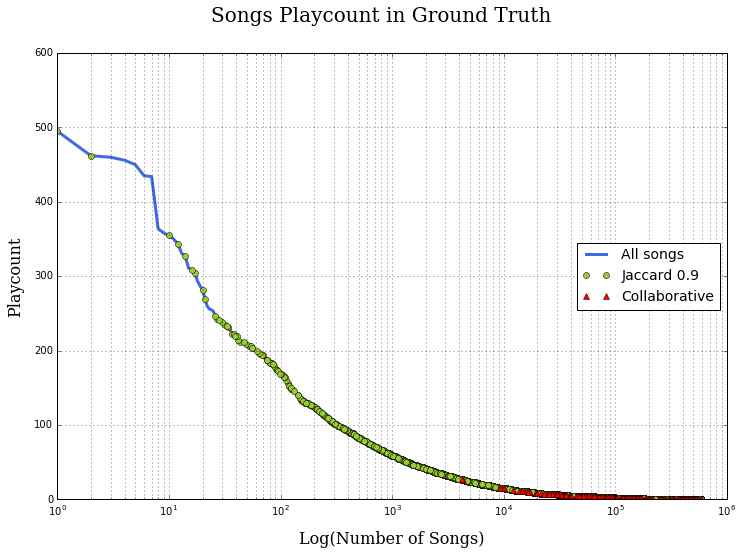

In [34]:
fig, ax1 = plt.subplots(figsize=(12,8))

plt.suptitle("Songs Playcount in Ground Truth", fontsize=20, fontdict = font_title  )
ax1.semilogx(x_gt, y_gt, 'royalblue', linewidth=3)
ax1.semilogx(gt_jac, y_gt_jac , color='yellowgreen', marker='o', linestyle = 'None', linewidth=1)
ax1.semilogx(gt_cl, y_gt_cl , color='red', marker='^', linestyle = 'None', linewidth=2)

ax1.grid(True, which="both")
ax1.set_xlabel('Log(Number of Songs)', fontdict = font_label, labelpad=30)
ax1.set_ylabel('Playcount', fontdict = font_label, labelpad=10)
ax1.legend(['All songs', 'Jaccard 0.9', 'Collaborative'], fontsize = 14, loc = 7)

#plt.savefig(DATA_PATH + 'playTest')